While looking for some details on t-tests, I ran across a this post from [The Minitab Blog](https://blog.minitab.com/blog/quality-data-analysis-and-statistics/punxsutawney-phil-and-his-2-sample-t-test) which investigated Punxsutawney Phil's powers of prognostication. The authors of that post tested whether there was a statistically significant difference in the average monthly temperature in the months immediately following Phil's prediction in years where he saw his shadow vs years when he did not see his shadow. The original blog post was a little unclear about where and how they obtained their temperature data, so I thought I'd perform a similar analysis with a sligthly clearer data lineage. Also, I'll be conducting my analysis in Python.

For this analysis, monthly average temperature data was obtained from [NOAA's Global Summary of the Month](https://www.ncdc.noaa.gov/cdo-web/datasets#GSOM) for Jefferson County PA, which is where [Punxsutawney](https://en.wikipedia.org/wiki/Punxsutawney,_Pennsylvania) is located. Phil's predictions were sourced from the Wikipedia entry for [Punxsutawney Phil](https://en.wikipedia.org/wiki/Punxsutawney_Phil), but the data provided there were originally sourced from [Stormfax.com](http://www.stormfax.com/ghogday.htm). The temperature data and the Wikipedia page (as of Apr-2020) are contained in [this repository](https://github.com/pkepley/blog-notebooks/tree/master/20200418_GroundHog).

In [1]:
import sys, os, re, requests, urllib3, pathlib
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from IPython.core.display import display, HTML

In [2]:
data_path = "./data/"
temperature_data_path = data_path + "/TempJeffersonCountyPA"

## Punxsutawney Phil Data

Because I didn't feel like copying down the data about Phil's predictions by hand, we will parse the Wiki page's summary.

To begin, let's download the page if we don't have it already (it's included in the repository).

In [3]:
ghog_pred_html = data_path + "/wiki_phil.html"

if not os.path.exists(ghog_pred_html):
    url = "https://en.wikipedia.org/wiki/Punxsutawney_Phil"
    req = requests.get(url)
    req_text = req.text
    
    with open(ghog_pred_html, 'w') as f:
        f.write(req_text)
        
else:
    with open(ghog_pred_html, 'r') as f:
        req_text = "".join(list(f))

We'll parse the web-page using Beautiful soup. So let's build the soup and find the table of Phil's predictions.

In [4]:
# build the soup
soup = BeautifulSoup(req_text, 'html.parser')

# find the only wikitable, which has the prognostications
table = soup.find('table', {'class' : 'wikitable'})
table_rows = table.find_all('tbody')

# We can throw away the table caption, since it links to 
# the original page
table.find("caption").decompose()

Before moving on, we'll render the table that we extracted. Some minor modifications were necessary to get this to look nice in this notebook.

In [5]:
# find the legend
legend = soup.find('div', attrs={'style' : 'float: left;'})
legend = legend.find("tbody")

# the legend was aligning right, so force it to align left
for div in legend.findAll("div", attrs={'class' : 'legend'}):
    div['style'] = 'text-align:left;'
    
# Render the html
display(HTML(table.prettify()))
display(HTML(legend.prettify()))

"""Long winter"" (103) ""Early spring"" (20) "" War clouds have blacked out parts of the shadow."" (1) No appearance (1) No record (9)"


Next we parse the table and use the table cell styles to determine whether Phil saw his shadow or not in each year. We will only retain the Long Winter (shadow seen) and Early Spring (no shadow) records, and will set all other records as missing.

In [6]:
# get all of the entries in the table, cell contents are years 
# and style denotes if a shadow was seen or not
tds = table.find_all('td', style=True)
years  = [int(td.text) for td in tds]
styles = [td['style'] for td in tds]

# use the color coding to identify if a s
shadow = []
for s in styles:
    if "azure" in s:
        shadow.append(True)   # azure = SHADOW
    elif "gold" in s:
        shadow.append(False)  # gold = NO SHADOW
    else:
        shadow.append(np.nan) # sometimes no records, once war clouds
        
# Create a dataframe of the records
df_phil = pd.DataFrame({"year" : years, "shadow" : shadow})
df_phil = df_phil[~df_phil["shadow"].isnull()]
df_phil.head()

,year,shadow
0,1887,True
1,1888,True
3,1890,False
11,1898,True
13,1900,True


## Temperature Data

The NOAA site only allows you to export "1000 year-records" at a time, so I had to split my request into two requests. Data is (partially) available for Jefferson County from 1892 onward. I requested records June-1892 through March-2020. The data consists of monthly temperature records from multiple stations in Jefferson County. For this analysis we will only be interested in the average temperature "TAVG." We'll drop the other columns and rename the columns we keep.

In [7]:
temperature_data_files = os.listdir(temperature_data_path)
temperature_data_file_paths = [temperature_data_path + "/" + f for f in temperature_data_files]
df_temperature = pd.concat((pd.read_csv(f) for f in temperature_data_file_paths))

print("Data file names")
print("---------------")
for f in temperature_data_files: 
    print(f)

# Build the data frame. Only retain average
df_temperature.columns = [c.lower() for c in df_temperature.columns]
df_temperature['date'] = pd.to_datetime(df_temperature['date'])
df_temperature = df_temperature[['station', 'date', 'tavg']]
df_temperature = df_temperature.rename(columns = {'tavg' : 't_avg'})
df_temperature = df_temperature.dropna()
df_temperature.head()

Data file names
---------------
jefferson_county_pa_temp_189206_195005.csv
jefferson_county_pa_temp_195006_202003.csv


,station,date,t_avg
0,USW00014741,1926-01-01,22.0
1,USW00014741,1926-02-01,23.6
2,USW00014741,1926-03-01,28.3
3,USW00014741,1926-04-01,40.0
4,USW00014741,1926-05-01,53.9


Next, we're not especially interested in the individual station's average observed temperature, so in each month we'll average across stations to get a representative value for Jefferson County. I'll add a couple columns for convenience later on.

In [8]:
df_montly_temperature = df_temperature.groupby('date').mean().reset_index()
df_montly_temperature['month'] = pd.DatetimeIndex(df_montly_temperature['date']).month
df_montly_temperature['year']  = pd.DatetimeIndex(df_montly_temperature['date']).year
df_montly_temperature = df_montly_temperature[['date', 'year', 'month', 't_avg']]
df_montly_temperature.head()

,date,year,month,t_avg
0,1896-09-01,1896,9,70.3
1,1896-10-01,1896,10,52.1
2,1896-11-01,1896,11,47.1
3,1897-01-01,1897,1,32.8
4,1897-02-01,1897,2,43.6


Here we provide a scatter-plot of the average temperature for each station and compare it to the mean across stations. 

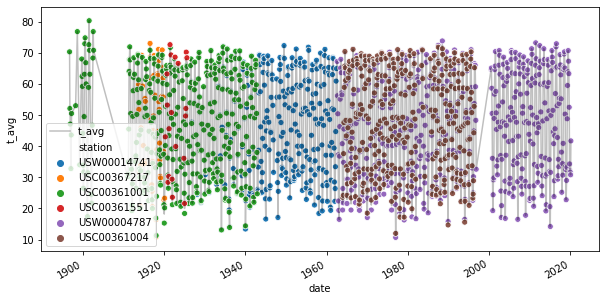

In [9]:
fig, ax = plt.subplots(figsize = (10,5))
df_montly_temperature.plot(x = 'date', y = 't_avg', ax = ax, c='k', alpha=0.25)
sns.scatterplot(x='date', y='t_avg', hue='station', data=df_temperature, ax=ax)
plt.show()

Next we create a dataframe of the average temperature for February through March. I'm ignoring the fact that February has fewer days than March, but a more careful analysis would not neglect that fact. This should be good enough. &#128578;

In [10]:
df_feb_mar_avg = (df_montly_temperature[(df_montly_temperature['month'] == 2) | (df_montly_temperature['month'] == 3)]
               .groupby('year')[['t_avg']]
               .agg(['count', 'mean']))
df_feb_mar_avg.columns = ['_'.join(col).strip() for col in df_feb_mar_avg.columns.values]
df_feb_mar_avg = df_feb_mar_avg.reset_index()
df_feb_mar_avg = df_feb_mar_avg[df_feb_mar_avg['t_avg_count'] == 2]
df_feb_mar_avg = df_feb_mar_avg[['year', 't_avg_mean']]
df_feb_mar_avg = df_feb_mar_avg.rename(columns = {'t_avg_mean' : 't_avg'})

In [11]:
df_feb_mar_avg.head()

,year,t_avg
0,1897,47.05
3,1900,29.10
4,1901,24.45
6,1911,32.95
7,1912,24.45


## 2-Sample Mean t-test

Finally we've got all of the data that we will need for the [t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html). Let's merge the two dataframes and throw away any years where we're missing a temperature measurement or we didn't have a prediction from Phil.

In [12]:
df_combined = pd.merge(df_phil, df_feb_mar_avg, left_on = "year", right_on = "year", how = "outer")
df_combined = df_combined.dropna()
df_combined.head()

,year,shadow,t_avg
4,1900,True,29.10
5,1901,True,24.45
15,1911,True,32.95
16,1912,True,24.45
17,1913,True,33.85


Let's take a quick look at the mean temperature for Feb-March in years when Phil saw his shadow, vs years when he didn't see his shadow.

In [13]:
df_combined.groupby('shadow').agg({'t_avg' : ['count', 'mean']})

t_avg           
       count       mean
shadow                 
False     16  30.596875
True      89  30.176966

The means are *pretty* similar. So I wouldn't expect our t-test to report a significant difference. Next we'll convert the temperature to vectors for the t-tests, plot the distribution of the means in each prediction class, and then we'll run the t-test. In the t-test, we'll assume the samples have the same variance, although Scipy can run [a test](https://en.wikipedia.org/wiki/Welch%27s_t-test) that allows for different variance between the different populations.

In [14]:
avg_temp_shadow    = df_combined[df_combined['shadow'] == True ]['t_avg'].to_numpy().flatten()
avg_temp_no_shadow = df_combined[df_combined['shadow'] == False]['t_avg'].to_numpy().flatten()

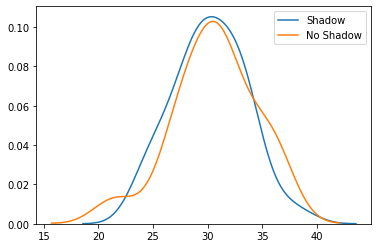

In [15]:
sns.distplot(avg_temp_shadow,    hist=False, label="Shadow")
sns.distplot(avg_temp_no_shadow, hist=False, label="No Shadow")
plt.show()

In [16]:
ttest_rslt = ttest_ind(avg_temp_shadow, avg_temp_no_shadow, 
                       equal_var=False)

print("T-Test Result")
print("-------------")
print("t-value: {}".format(ttest_rslt.statistic))
print("p-value: {}".format(ttest_rslt.pvalue))

T-Test Result
-------------
t-value: -0.4104841358882534
p-value: 0.6859415624804476


We fail to reject the null hypothesis that the two means are equal. So we cannot conclude that the means are different, however, we still can't conclude that the means are equal. But this would reduce my confidence in Phil just a bit. &#128578;